In [1]:
## Import the keras bits we need
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import keras
import math
import sklearn
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras import layers, metrics
from keras.utils import np_utils
from keras.objectives import categorical_crossentropy
from keras.datasets import mnist
from keras.regularizers import l1, l2
from sklearn import manifold
from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.utils.extmath import _ravel

Using TensorFlow backend.


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE


In [2]:
df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata/mosquitos_country.dat", '\t')
df.head(10)

df = df[df['RearCnd']!='VF']

Species_counts = df.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df.groupby('Age').size()
print('{}'.format(age_counts))
country_counts = df.groupby('Country').size()
print('{}'.format(country_counts))

X = df.iloc[:,6:]
y_age = df["Age"]
y_species = df["Species"]
y_status = df["Status"]
y_country = df["Country"]

print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))
print('shape of y country : {}'.format(y_country.shape))

X = np.asarray(X)
y_age = np.asarray(y_age)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)
y_country = np.asarray(y_country)

Species
AA    15030
AC     4401
AG    12545
dtype: int64
Status
BF     6361
GR     6188
SF    19427
dtype: int64
RearCnd
TF     6495
TL    25481
dtype: int64
Age
1      852
2      812
3     1035
4     1263
5     1736
6     1719
7     2020
8     2078
9     2255
10    2149
11    2328
12    2120
13    2432
14    2168
15    2345
16    2232
17    2432
dtype: int64
Country
B     5571
S     5667
T    20738
dtype: int64
shape of X : (31976, 1625)
shape of y age : (31976,)
shape of y species : (31976,)
shape of y status : (31976,)
shape of y country : (31976,)


In [3]:
# Scale and visualize the embedding vectors
def plot_embedding_Age(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        indicies = np.where(Species==uniqueSpecies[i])[0]
        plt.scatter(X[indicies, 0], X[indicies, 1], c=y[indicies], cmap=colorMap, s=5)         
        plt.xticks([]), plt.yticks([])
        plt.title(uniqueSpecies[i])
    plt.colorbar()    
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")

# Scale and visualize the embedding vectors
def plot_embedding_Malaria(X, y, saveDir=None, title=None):
    ## Sort tStandardScaler().fit_transform(X=he data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
      
    ## Start plotting
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(1,1,1)
    indicies = np.where(y==0)[0]
    Malaria_label = 'No Malaria'
    plt.scatter(X[indicies, 0], X[indicies, 1], color = 'b', label=Malaria_label)         
    indicies = np.where(y==1)[0]
    Malaria_label = 'Malaria'
    plt.scatter(X[indicies, 0], X[indicies, 1], color = 'r', label=Malaria_label)         
    plt.xticks([]), plt.yticks([])
    plt.legend()  
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")

# Scale and visualize the embedding vectors
def plot_embedding_Species(X, y, Species=None, saveDir=None, title=None):
    color_choice = ['bo', 'ro']
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    colors = ['b', 'r', 'g']
    ## Start plotting
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(1,1,1)
    for i in range(len(uniqueSpecies)):
        indicies = np.where(Species==uniqueSpecies[i])[0]
        Species_label = Species[indicies[0]]
        plt.scatter(X[indicies, 0], X[indicies, 1], color = colors[i], label=Species_label)         
         
    plt.xticks([]), plt.yticks([])
    plt.legend()
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")
    
def plot_embedding_country(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'o', 'p']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'S':
                    y_label.append('Glasgow')
                elif lab == 'T':
                    y_label.append('Ifakara')
                elif lab == 'B':
                    y_label.append('Bobo')
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis')
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii')
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae')
        plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")
    
def plot_embedding_status(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'o', 'p']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'BF':
                    y_label.append('Blood Fed')
                elif lab == 'GR':
                    y_label.append('Gravid')
                elif lab == 'SF':
                    y_label.append('Sugar Fed')
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis')
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii')
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae')
        plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")


In [4]:
# tsnemod2d = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, 
#                learning_rate=50.0, n_iter=2000, n_iter_without_progress=400, 
#                min_grad_norm=1e-07, metric='euclidean', init='pca', 
#                verbose=1, random_state=None, method='exact', angle=0.5)
tsnemod2d = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, 
               learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, 
               min_grad_norm=1e-07, metric='euclidean', init='pca', 
               verbose=1, random_state=None, method='exact', angle=0.5)
features_embedded_2d = tsnemod2d.fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 31976
[t-SNE] Computed conditional probabilities for sample 2000 / 31976
[t-SNE] Computed conditional probabilities for sample 3000 / 31976
[t-SNE] Computed conditional probabilities for sample 4000 / 31976
[t-SNE] Computed conditional probabilities for sample 5000 / 31976
[t-SNE] Computed conditional probabilities for sample 6000 / 31976
[t-SNE] Computed conditional probabilities for sample 7000 / 31976
[t-SNE] Computed conditional probabilities for sample 8000 / 31976
[t-SNE] Computed conditional probabilities for sample 9000 / 31976
[t-SNE] Computed conditional probabilities for sample 10000 / 31976
[t-SNE] Computed conditional probabilities for sample 11000 / 31976
[t-SNE] Computed conditional probabilities for sample 12000 / 31976
[t-SNE] Computed conditional probabilities for sample 13000 / 31976
[t-SNE] Computed conditional probabilities for sample 14000 / 31976
[t-SNE] Computed 

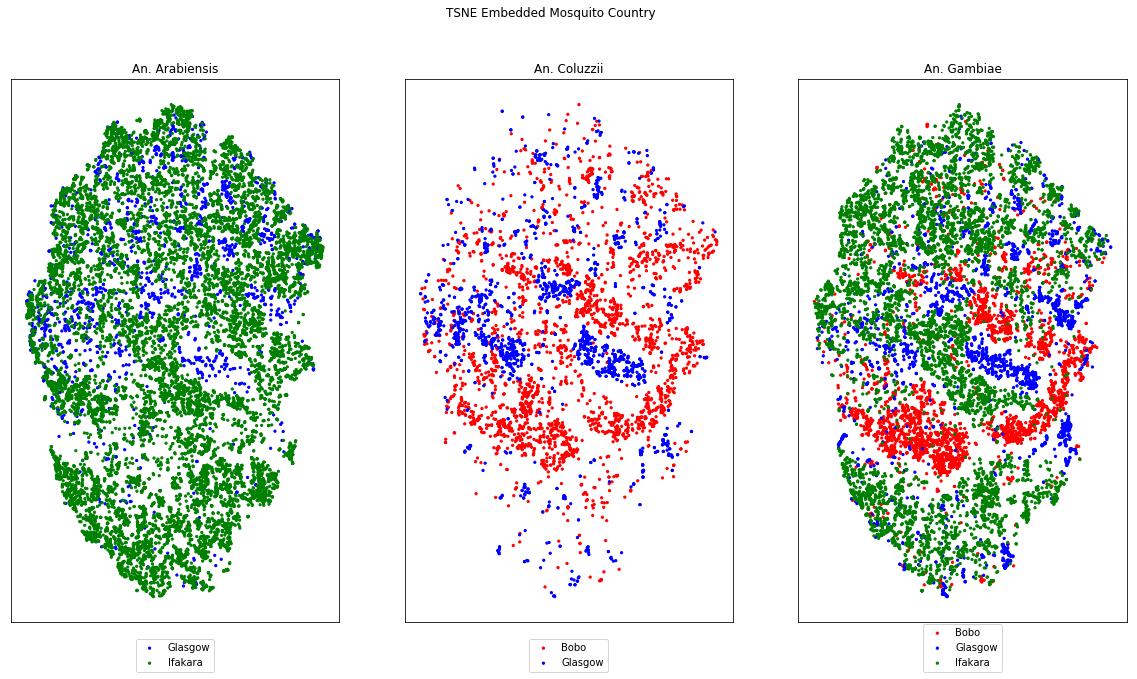

In [5]:
saveDir = '/home/josh/Documents/Mosquito_Project/New_Data/Models/Dimension_Reduction/TSNE/outputs/MIMI_data/'

plot_embedding_country(features_embedded_2d, y_country, y_species, saveDir, ('TSNE Embedded Mosquito Country'), colorMap='Set1')


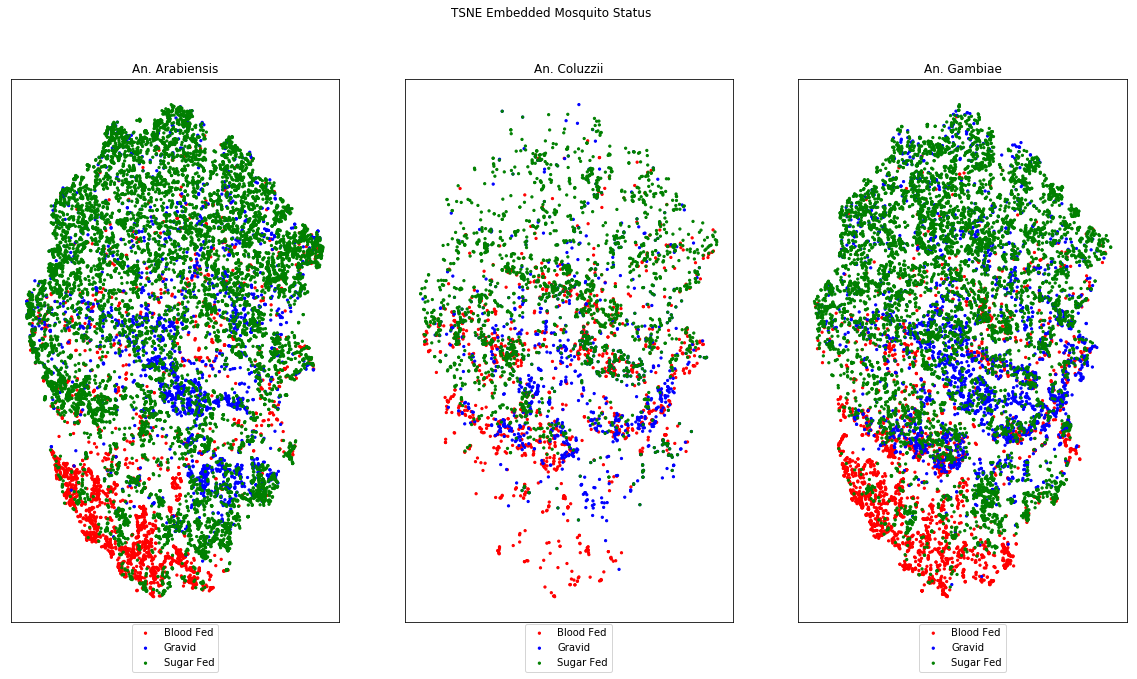

In [7]:
saveDir = '/home/josh/Documents/Mosquito_Project/New_Data/Models/Dimension_Reduction/TSNE/outputs/MIMI_data/'

plot_embedding_status(features_embedded_2d, y_status, y_species, saveDir, ('TSNE Embedded Mosquito Status'), colorMap='Set1')


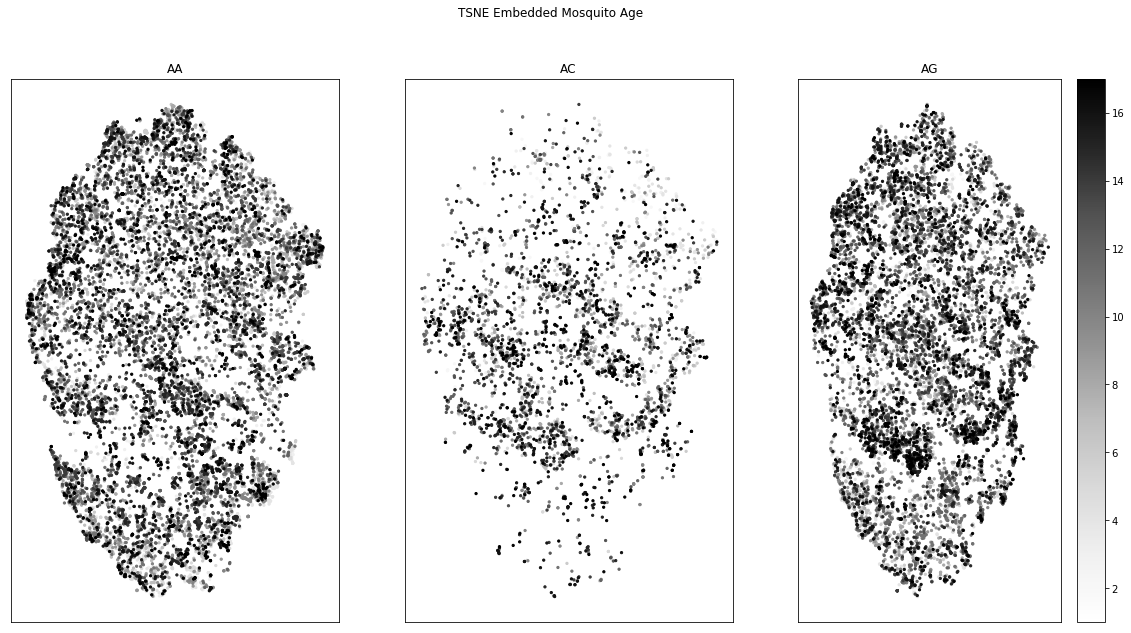

In [10]:
saveDir = '/home/josh/Documents/Mosquito_Project/New_Data/Models/Dimension_Reduction/TSNE/outputs/MIMI_data/'

plot_embedding_Age(features_embedded_2d, y_age, y_species, saveDir, ('TSNE Embedded Mosquito Age'))


In [3]:
df_all = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata/mosquitos_country.dat", '\t')
df_all.head(10)

df_all = df_all[df_all['Country']!='S']

Species_counts_all = df_all.groupby('Species').size()
print('{}'.format(Species_counts_all))
Status_counts_all = df_all.groupby('Status').size()
print('{}'.format(Status_counts_all))
RearCnd_counts_all = df_all.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts_all))
age_counts_all = df_all.groupby('Age').size()
print('{}'.format(age_counts_all))
country_counts_all = df_all.groupby('Country').size()
print('{}'.format(country_counts_all))

X_all = df_all.iloc[:,6:]
y_age_all = df_all["Age"]
y_species_all = df_all["Species"]
y_status_all = df_all["Status"]
y_country_all = df_all["Country"]
y_rearcnd_all = df_all["RearCnd"]

print('shape of X : {}'.format(X_all.shape))
print('shape of y age : {}'.format(y_age_all.shape))
print('shape of y species : {}'.format(y_species_all.shape))
print('shape of y status : {}'.format(y_status_all.shape))
print('shape of y country : {}'.format(y_country_all.shape))
print('shape of y rearcnd : {}'.format(y_rearcnd_all.shape))

X_all = np.asarray(X_all)
y_age_all = np.asarray(y_age_all)
y_species_all = np.asarray(y_species_all)
y_status_all = np.asarray(y_status_all)
y_country_all = np.asarray(y_country_all)
y_rearcnd_all = np.asarray(y_rearcnd_all)

Species
AA    14594
AC     2786
AG    11614
dtype: int64
Status
BF     4758
GR     4668
SF    19568
dtype: int64
RearCnd
TF     6495
TL    19814
VF     2685
dtype: int64
Age
1      846
2      584
3      719
4     1314
5     1469
6     1568
7     1862
8     2070
9     1979
10    2115
11    2009
12    1965
13    2175
14    2145
15    2190
16    1993
17    1991
dtype: int64
Country
B     6035
T    22959
dtype: int64
shape of X : (28994, 1625)
shape of y age : (28994,)
shape of y species : (28994,)
shape of y status : (28994,)
shape of y country : (28994,)
shape of y rearcnd : (28994,)


In [4]:
def plot_embedding_rearCnd(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'o', 'p']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'TF':
                    y_label.append('Time Course Field')
                elif lab == 'TL':
                    y_label.append('Time Course Lab')
                elif lab == 'VF':
                    y_label.append('Validation Field')
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
#             print(indicies)
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

#         plt.ylim([0,0.4])
#         plt.xlim([0.5,1.0])
        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis')
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii')
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae')
        plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")

In [5]:
tsnemod2d_all = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, 
               learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, 
               min_grad_norm=1e-07, metric='euclidean', init='pca', 
               verbose=1, random_state=None, method='exact', angle=0.5)
features_embedded_2d_all = tsnemod2d_all.fit_transform(X_all)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 28994
[t-SNE] Computed conditional probabilities for sample 2000 / 28994
[t-SNE] Computed conditional probabilities for sample 3000 / 28994
[t-SNE] Computed conditional probabilities for sample 4000 / 28994
[t-SNE] Computed conditional probabilities for sample 5000 / 28994
[t-SNE] Computed conditional probabilities for sample 6000 / 28994
[t-SNE] Computed conditional probabilities for sample 7000 / 28994
[t-SNE] Computed conditional probabilities for sample 8000 / 28994
[t-SNE] Computed conditional probabilities for sample 9000 / 28994
[t-SNE] Computed conditional probabilities for sample 10000 / 28994
[t-SNE] Computed conditional probabilities for sample 11000 / 28994
[t-SNE] Computed conditional probabilities for sample 12000 / 28994
[t-SNE] Computed conditional probabilities for sample 13000 / 28994
[t-SNE] Computed conditional probabilities for sample 14000 / 28994
[t-SNE] Computed 

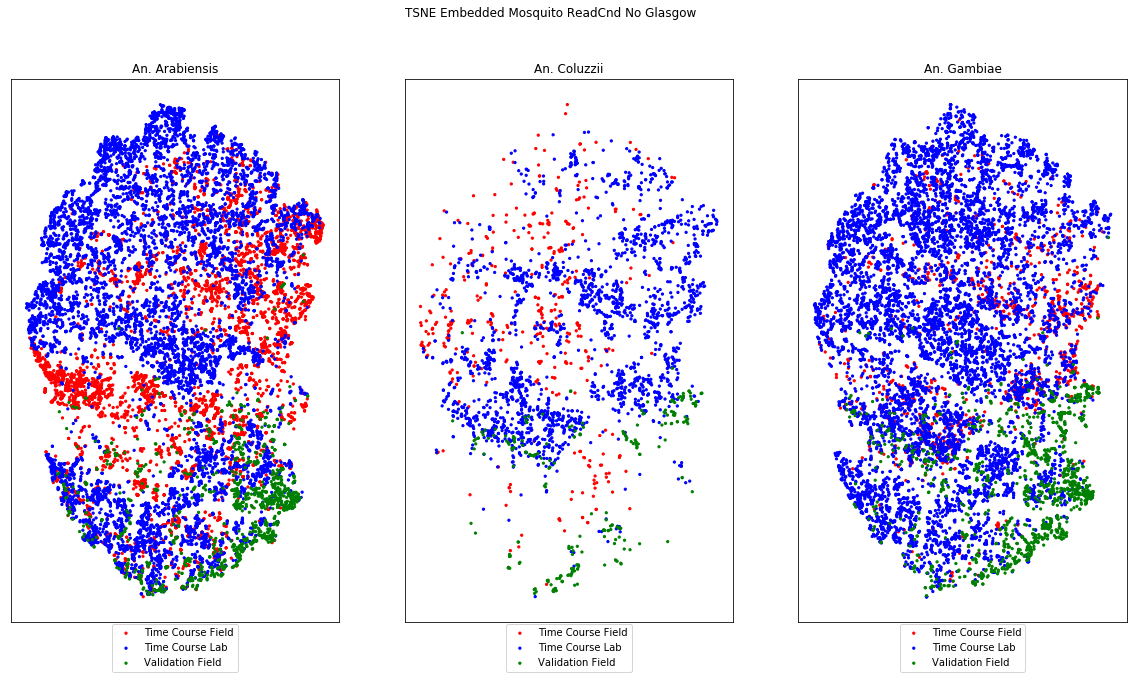

In [6]:
saveDir = '/home/josh/Documents/Mosquito_Project/New_Data/Models/Dimension_Reduction/TSNE/outputs/MIMI_data/'

plot_embedding_rearCnd(features_embedded_2d_all, y_rearcnd_all, y_species_all, saveDir, ('TSNE Embedded Mosquito ReadCnd No Glasgow'), colorMap='Set1')
